# StyleGANS

In [14]:
import tqdm
import json
import os
import tabulate
from PIL import Image
import gen_images
import numpy as np

In [3]:
print("you are here:", os.getcwd())

you are here: /scratch


In [4]:
def get_training_options(run):
    rundir = os.path.join('training-runs', run)
    with open (os.path.join(rundir, 'training_options.json')) as fp:
        return json.load(fp)

In [5]:
def preview_snapshot(run, snapshot, cols = 1, rows = 1):
    nr = snapshot[17:-4]
    file = os.path.join('training-runs', run, f"fakes{nr}.png")
    img = Image.open(file)
    training = get_training_options(run)
    return img.crop((0,0, training["training_set_kwargs"]["resolution"] * cols, training["training_set_kwargs"]["resolution"] * rows))

In [6]:
# gather directories with trained networks

run_dirs = sorted(os.listdir('training-runs'))
runs = []
for run in run_dirs:
    rundir = os.path.join('training-runs', run)
    snaps = [f for f in os.listdir(rundir) if f.startswith('network-snapshot')]
    snaps = sorted(snaps)
    if len(snaps) < 1:
        continue
    
    with open (os.path.join(rundir, 'training_options.json')) as fp:
        training = json.load(fp)
    
    
    fakes = sorted([f for f in os.listdir(rundir) if f.startswith('fake')])
    
    # if len(fakes):
    #     img = Image.open(os.path.join(rundir, fakes[-2])) # last image is the _init.png
    #     img = img.crop((0,0, training["training_set_kwargs"]["resolution"], training["training_set_kwargs"]["resolution"]))
    #     #img.crop((training["training_set_kwargs"]["resolution"], training["training_set_kwargs"]["resolution"]))
    # else:
    #     img = None
    
    runs.append({
        "run": run,
        "latest_snapshot": snaps[-1],
        "dataset": os.path.split(os.path.dirname(training["training_set_kwargs"]["path"]))[1],
        "conditional_dataset": training["training_set_kwargs"]["use_labels"],
        "resolution": training["training_set_kwargs"]["resolution"],
        "gamma": training["loss_kwargs"],
       # "preview": img.size
    })

tabulate.tabulate(runs, tablefmt='html', headers="keys", colalign=("left","left"))

'<table>\n<thead>\n<tr><th>run                                      </th><th>latest_snapshot            </th><th>dataset  </th><th>conditional_dataset  </th><th style="text-align: right;">  resolution</th><th>gamma                                                                                                         </th></tr>\n</thead>\n<tbody>\n<tr><td>00001-stylegan3-t--gpus1-batch32-gamma8.2</td><td>network-snapshot-002600.pkl</td><td>paris3   </td><td>True                 </td><td style="text-align: right;">         256</td><td>{&#x27;class_name&#x27;: &#x27;training.loss.StyleGAN2Loss&#x27;, &#x27;r1_gamma&#x27;: 8.2}                                                </td></tr>\n<tr><td>00002-stylegan3-t--gpus1-batch32-gamma2  </td><td>network-snapshot-006560.pkl</td><td>paris3   </td><td>True                 </td><td style="text-align: right;">         256</td><td>{&#x27;class_name&#x27;: &#x27;training.loss.StyleGAN2Loss&#x27;, &#x27;r1_gamma&#x27;: 2.0}                                                </td></tr>\n<tr><td>00003-stylegan3-r--gpus1-batch32-gamma2  </td><td>network-snapshot-022960.pkl</td><td>paris3   </td><td>True                 </td><td style="text-align: right;">         256</td><td>{&#x27;class_name&#x27;: &#x27;training.loss.StyleGAN2Loss&#x27;, &#x27;r1_gamma&#x27;: 2.0, &#x27;blur_init_sigma&#x27;: 10, &#x27;blur_fade_kimg&#x27;: 200.0}</td></tr>\n</tbody>\n</table>'

Pick a run from above, and assign it to `run`.

In [8]:
run = "00003-stylegan3-r--gpus1-batch32-gamma2"
snapshot = "network-snapshot-022960.pkl"

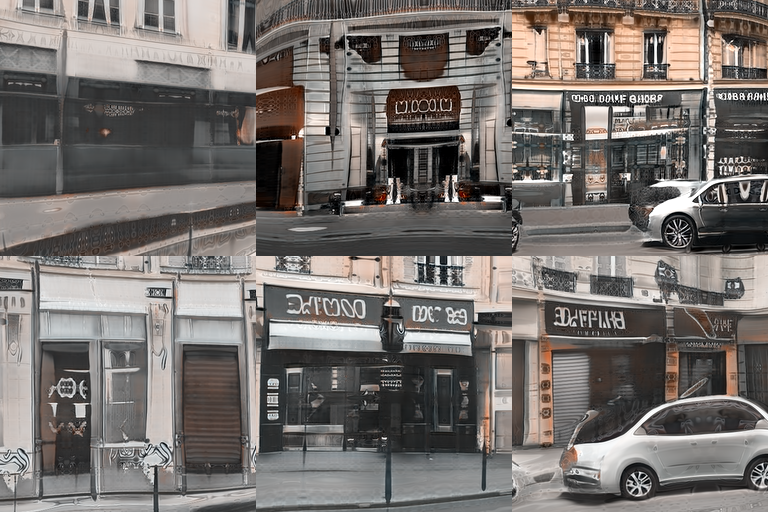

In [9]:
preview_snapshot(run,snapshot, 3, 2)

In [ ]:
# rerun this cell after changes to gen_images.py file
import importlib
importlib.reload(gen_images)

In [ ]:
for z, img, filename in gen_images.generate_images(
    f"training-runs/{run}/{snapshot}",
    gen_images.parse_range("0-2"),
    "out",
    truncation_psi=1,
    class_idx=0
):
    print(filename)
    display(img)
    img.save(filename)

In [24]:
import torch
import legacy
import dnnlib
device = torch.device('cuda')

In [36]:
psi=1.0
all_seeds = gen_images.parse_range("0-2")
class_idx = 0

[0, 1, 2]


In [65]:
# adapted from https://github.com/dvschultz/stylegan2-ada-pytorch/blob/9b6750b96dc9841816e8ac57b05f395d0f23c30d/generate.py

def seeds_to_zs(G,seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        z = np.random.RandomState(seed).randn(1, G.z_dim)
        zs.append(z)
    return zs

# slightly modified version of
# https://github.com/PDillis/stylegan2-fun/blob/master/run_generator.py#L399
def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    '''
    Spherical linear interpolation
    Args:
        t (float/np.ndarray): Float value between 0.0 and 1.0
        v0 (np.ndarray): Starting vector
        v1 (np.ndarray): Final vector
        DOT_THRESHOLD (float): Threshold for considering the two vectors as
                               colineal. Not recommended to alter this.
    Returns:
        v2 (np.ndarray): Interpolation vector between v0 and v1
    '''
    v0 = v0.cpu().detach().numpy()
    v1 = v1.cpu().detach().numpy()
    # Copy the vectors to reuse them later
    v0_copy = np.copy(v0)
    v1_copy = np.copy(v1)
    # Normalize the vectors to get the directions and angles
    v0 = v0 / np.linalg.norm(v0)
    v1 = v1 / np.linalg.norm(v1)
    # Dot product with the normalized vectors (can't use np.dot in W)
    dot = np.sum(v0 * v1)
    # If absolute value of dot product is almost 1, vectors are ~colineal, so use lerp
    if np.abs(dot) > DOT_THRESHOLD:
        return lerp(t, v0_copy, v1_copy)
    # Calculate initial angle between v0 and v1
    theta_0 = np.arccos(dot)
    sin_theta_0 = np.sin(theta_0)
    # Angle at timestep t
    theta_t = theta_0 * t
    sin_theta_t = np.sin(theta_t)
    # Finish the slerp algorithm
    s0 = np.sin(theta_0 - theta_t) / sin_theta_0
    s1 = sin_theta_t / sin_theta_0
    v2 = s0 * v0_copy + s1 * v1_copy
    return torch.from_numpy(v2).to("cuda")

def slerp_interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(slerp(fraction,zs[i],zs[i+1]))
    return out

def zs_to_ws(G,device,label,truncation_psi,zs):
    ws = []
    for z_idx, z in enumerate(zs):
        z = torch.from_numpy(z).to(device)
        w = G.mapping(z, label, truncation_psi=truncation_psi, truncation_cutoff=8)
        ws.append(w)
    return ws



def images(G,device,inputs,space,truncation_psi,label,noise_mode,outdir,start=None,stop=None):
    if(start is not None and stop is not None):
        tp = start
        tp_i = (stop-start)/len(inputs)

    for idx, i in enumerate(inputs):
        # print('Generating image for frame %d/%d ...' % (idx, len(inputs)))
        
        if (space=='z'):
            z = torch.from_numpy(i).to(device)
            if(start is not None and stop is not None):
                img = G(z, label, truncation_psi=tp, noise_mode=noise_mode)
                tp = tp+tp_i
            else:
                img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        else:
            if len(i.shape) == 2: 
              i = torch.from_numpy(i).unsqueeze(0).to(device)
            img = G.synthesis(i, noise_mode=noise_mode, force_fp32=True)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        yield f"{idx:04d}", Image.fromarray(img[0].cpu().numpy(), 'RGB')

def interpolate(G,device,projected_w,seeds,random_seed,space,truncation_psi,label,frames,noise_mode,outdir,interpolation,
                easing, diameter, start=None,stop=None):
    if(interpolation=='noiseloop' or interpolation=='circularloop'):
        if seeds is not None:
            print(f'Warning: interpolation type: "{interpolation}" doesn’t support set seeds.')

        if(interpolation=='noiseloop'):
            points = noiseloop(frames, diameter, random_seed)
        elif(interpolation=='circularloop'):
            points = circularloop(frames, diameter, random_seed, seeds)

    else:
        if projected_w is not None:
            points = np.load(projected_w)['w']
        else:
            # get zs from seeds
            points = seeds_to_zs(G,seeds)  
            # convert to ws
            if(space=='w'):
                points = zs_to_ws(G,device,label,truncation_psi,points)

        # get interpolation points
        if(interpolation=='linear'):
            points = line_interpolate(points,frames,easing)
        elif(interpolation=='slerp'):
            points = slerp_interpolate(points,frames)
            
    # generate frames
    for idx, img in images(G,device,points,space,truncation_psi,label,noise_mode,outdir,start,stop):
        yield idx, img

In [26]:
with dnnlib.util.open_url(f"training-runs/{run}/{snapshot}") as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore



In [32]:
# Labels.
label = torch.zeros([1, G.c_dim], device=device)
if G.c_dim != 0:
    if class_idx is None:
        raise click.ClickException('Must specify class label with --class when using a conditional network')
    label[:, class_idx] = 1
else:
    if class_idx is not None:
        print ('warn: --class=lbl ignored when running on an unconditional network')

interpoliting images
0000


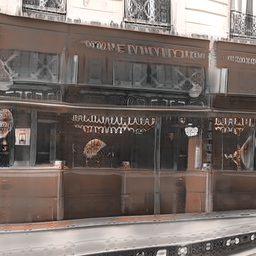

0001


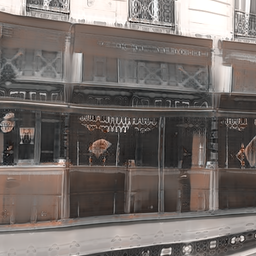

0002


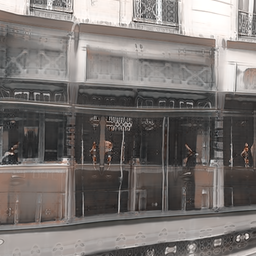

0003


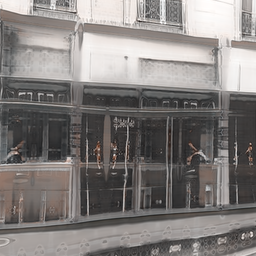

0004


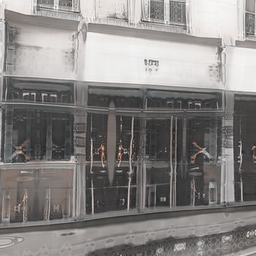

0005


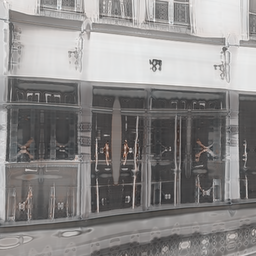

0006


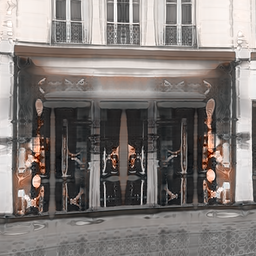

0007


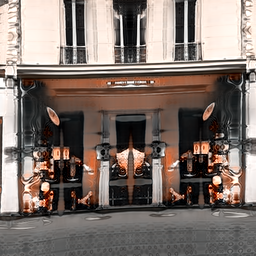

0008


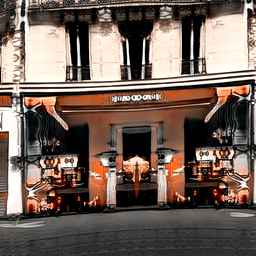

0009


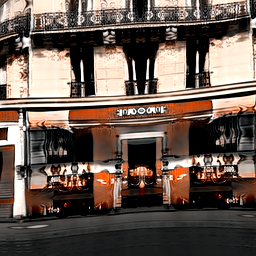

In [67]:
print("interpoliting images")
for idx, img in interpolate(G,device, None, all_seeds,None,'w',psi,label,5,'const','out/test','slerp',None, None):
    print(idx)
    display(img)

In [34]:
zs = torch.from_numpy(np.stack([np.random.RandomState(seed).randn(G.z_dim) for seed in all_seeds])).to(device)

ws = G.mapping(z=zs, c=label, truncation_psi=psi)
_ = G.synthesis(ws[:1]) # warm up
ws = ws.reshape(grid_h, grid_w, num_keyframes, *ws.shape[1:])


AssertionError: Wrong number of dimensions: got 3, expected 2

In [ ]:

# Interpolation.
grid = []
for yi in range(grid_h):
    row = []
    for xi in range(grid_w):
        x = np.arange(-num_keyframes * wraps, num_keyframes * (wraps + 1))
        y = np.tile(ws[yi][xi].cpu().numpy(), [wraps * 2 + 1, 1, 1])
        interp = scipy.interpolate.interp1d(x, y, kind=kind, axis=0)
        row.append(interp)
    grid.append(row)

In [ ]:
!pbaylies_projector.py